# Bee Foraging ABM
Based on Sam Woodman's Netlogo thesis model. Uses the agentpy ABM library.

Agenda Link: https://docs.google.com/document/d/14XbNdPlWMOrtLd1-0m3qUxlsR7LnDEyibB5Zos93G6w/

[//]: <> (Comment: markdown syntax guie https://www.markdownguide.org/basic-syntax#code-blocks)

### Current state of model:
Attribute                  | Status          | .
:-------------:            | :-------------: | :-------------:
**Agents have positions?** | Yes             | ✅
**Bees can move?**         | Yes             | ✅
**Model animated?**        | Buggy           | 🐜
**Memory?**                | No              | ❌
**Communication?**         | No              | ❌


### Simplifications:
* **Resources:** 
    * Randomly distributed
    * All patches are the same size
    * No difference in quality / quantity
    * Cannot be depleted / are not ephemeral
    
* **Bee movement:** 
    * Random angle from -45º to 45º relative to current orientation. 
    * Distance pulled from uniform distribution from 0 to dist_per_tick parameter 
        * (dist_per_tick is used for distance bees move per tick when returning to hive)
    * Foraging time at resource is constant
    
* **Communication:** Off

* **Memory:** Off

### Other assumptions:
* Bees can overlap each other
* Bees more slower when exploring than they do when returning
* Bees return directly to hive in a straight line
* Bees only forage at one resource per trip
* Bees are not influenced by the presence of other bees on nearby resources
* The landscape is square, and the hive is in the center
* The returning bees don't spend any time unloading pollen/nectar (they can forage again immediately)

### Known issues:
* **General**
    * I think there might be some weird stuff with the order you need to run the chunks- not totally sure about that though

* **Animations**
    * One has the bees the same color as the plants (confusing!)
    * The other crashes when you hit the play button
    
* **Beehavior**
    * In some cases, the angle for a bee's return to hive should be negative (all values given now are positive)
        * Can be easily repared with an if statement for cases, looking to see if there's a more elegant solution


██████████████████████████████████████████

### The below cell allows us to change the background of color other cells! 

This works in Jupyter, but I'm not sure about other ipython viewers.
Changing the color might sound superfluous, but I guarantee it's super, super helpful for clarifying which class you're looking at.

#### Here's how to use it:
1. Run the below cell
2. For each cell:
    1. Un-comment the first line (it should look like `#%%bgc #FFB7B2`)
    2. Run the cell
    3. Re-comment the first line
3. You're done!

In [1]:
# https://www.w3schools.com/colors/colors_palettes.asp
# https://stackoverflow.com/questions/49429585/how-to-change-the-background-color-of-a-single-cell-in-a-jupyter-notebook-jupy#comment104601184_50824920
from IPython.core.magic import register_cell_magic
from IPython.display import HTML, display
my_palette = ['#edc6a3','#f4ce88','#f0e9ee','#cbcfd9','#c9dac7','#d1d3be','#efe1d5','#e6b4a7','#c0b6a2','#cdb090']
my_palette_names = {'getter':'#e6b4a7', 'init':'#efe1d5'} 
@register_cell_magic
def bgc(color, cell=None):
    if str.isdigit(color) and len(color) == 1:
        color = my_palette[int(color)]
    else:
        color = my_palette_names.get(color, color)
    script = ("var cell = this.closest('.code_cell');"
    "var editor = cell.querySelector('.input_area');"
    "editor.style.background='{}';"
    "this.parentNode.removeChild(this)").format(color) 
    display(HTML('<img src onerror="{}">'.format(script)))

██████████████████████████████████████████

This model is built using agentpy in an object-oriented way. Each kind of agent (here bees, resources, and the hive) has its own class. The model itself is also a class, called `ForagingModel`. 

Agents are created as instances of their respective classes. They are created with certain variable values (defined by their class), such as their position and state. They can be grouped together by these variables in groups called AgentLists.

In [43]:
#%%bgc #FFB7B2

#Model
import agentpy as ap
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
import ipysimulate as ips
from ipywidgets import AppLayout

██████████████████████████████████████████

In [117]:
#%%bgc #FFDAC1

class Bee(ap.Agent):
    """ 
    An individual bee from the colony that forages
    """
    
    def setup(self):  
        """ 
        Initialize variables at agent creation 
        """
        
        self.Model = model47     # Connect the bee to an instance of the model
        self.kind = "bee"        # Used to color-code animation
        self.state_number = 0    # Used to color-code animation, 0 = Inactive
        
        self.orientation = model47.nprandom.uniform(low = 0.0, high = 360.0) 
        # Choose random starting orientation
        # Orientation is the direction the bee is facing [degrees] 
        # East (to the right) is 0º
        
        self.state = "inactive"  # All bees start at the hive
        
        # Possible states (strings)
        #   "inactive":   At the hive                  0
        #   "searching":  Random foraging              1
        #   "foraging":   Found a resource             2
        #   "returning":  En route back to the hive    3
        
        self.time_searching = 0  # How long bee was last "searching" for [UNIT: ticks]
        self.time_foraging  = 0  # How long bee was last "foraging"  for [UNIT: ticks]
        self.time_returning = 0  # How long bee was last "returning" for [UNIT: ticks]
        
    #===========================================================#

    def setup_pos(self, space):
        """
        Construct (continuous) environment
        """
        self.space = space 
        self.neighbors = space.neighbors
        self.pos = space.positions[self]
    
    #===========================================================#
        
    def move_radially(self, agent, move_dist, move_angle):
        """
        Move according to a specified distance and angle.
        move_angle is relative to the direction the bee is currently pointed in
        """
        global_angle = agent.orientation + move_angle 
        # Global angle is angle CCW to the horizontal
        # [Double check this is correct]
        
        # Bee's current coords
        current_x = agent.pos[0] 
        current_y = agent.pos[1]
        # Bee's new coords
        new_x = current_x + move_dist * np.cos(global_angle)
        new_y = current_y + move_dist * np.sin(global_angle)
        
        # Move! That! Bee!
        self.pos = [new_x,new_y]
        self.Model.space.move_to(self, self.pos)
    
    #===========================================================#
        
    def which_resources_found(self, agent):
        """
        Detect the resources a bee is currently on top of
        Returns a list of resources
        (called for foraging bees at each timestep)
        """
        self.on_resource = [] # We'll fill this list with the IDs of resources the bee is on
        
        # For each resource...
        for r in self.model.resources:
            
            # If the x values of the plant's bounding box contain the bee...
            if r.range_x[0] <= self.pos[0] <= r.range_x[1]:
                
                # and if the bounding box's y values ALSO contain the bee... 
                if r.range_y[0] <= self.pos[1] <= r.range_y[1]:
                    
                    # AND if the distance from bee to plant is ≤ the radius of the plant...
                    dist_to_resource = np.sqrt(abs((r.pos[0]-self.pos[0])**2 + (r.pos[1]-self.pos[1])**2))
                    if dist_to_resource <= r.radius:
                        
                        # then we say that the bee is on top of that specific plant.
                        self.on_resource += [r.id] # Add the plant's ID to the list of resources the bee is on
        
        # After having done this for all of the resources in the environment,
        # give the bee the list of resources it is on top of
        return self.on_resource
    
    #===========================================================#

    
    def dist_btwn(self, coordsA, coordsB):
        """
        Given two (2D) points, find the Cartesian distance between them
        """
        x1 = coordsA[0]
        x2 = coordsB[0]
        y1 = coordsA[1]
        y2 = coordsB[1]
        return np.sqrt((x1-x2)**2+(y1-y2)**2)
    
    #=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=# 
    ##=#=#=#=#=#=#=#=#=#=#=#  STATES  #=#=#=#=#=#=#=#=#=#=#=#=#=#
    #=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=# 
    
    def be_inactive(self):
        """ 
        What the inactive bees do each timestep 
        """

        rg = self.model.random  # Set up random number generator

        if self.p.p_random_forage > rg.random():
            self.time_searching = 0    # Reset time searching counter
            self.state = "searching"
            self.state_number = 1

    #===========================================================#
            
    def search(self):
        """ 
        What the searching bees do each timestep 
        """
        
        # Randomly choose direction and distance
        move_dist = model47.nprandom.uniform(low = 0.0, high = self.p.dist_per_tick)
        move_angle = model47.nprandom.uniform(low = -45, high = 45) # relative to current orientation
        
        # Move according to that direction and distance
        self.move_radially(self, move_dist, move_angle)
        
        self.time_searching += 1                           # Add 1 tick to the "time spent searching" counter
        resources_found = self.which_resources_found(self) # Check if bee is above any resources
        
        if resources_found != []:       # If bee is above a resource, change its state to foraging
            self.state = "foraging"
            self.state_number = 2
            
        elif self.time_searching >= self.p.give_up_threshold:  # If it's been out for a long time, go home
            self.state = "returning"
            self.state_number = 3
            
        else:                           # Otherwise, continue searching
            self.state = "searching"
            self.state_number = 1

    #===========================================================#
            
    def forage(self):
        """ 
        What the foraging bees do each timestep 
        """
        
        self.time_foraging += 1         # Add 1 tick to the "time spent foraging" counter
        
        # ticks_on_resource is a parameter we set.
        # It represents how long a bee spends on a resource before going home
        
        if self.time_foraging >= self.p.ticks_on_resource:
            self.time_returning = 0
            self.state = "returning"
            self.state_number = 3
    
    #===========================================================#
    
    def go_home(self):
        """ 
        What the returning bees do each timestep 
        """        
        
        # Bee's current position
        current_x = self.pos[0]
        current_y = self.pos[1]

        # If the bee is close enough to the hive (i.e. it could get there
        # within one timestep), it goes there.
        
        if self.dist_btwn(self.pos, [self.p.land_size/2, self.p.land_size/2]) <= self.p.dist_per_tick:
            
            # Move to the hive
            self.pos = [self.p.land_size/2,self.p.land_size/2]
            self.Model.space.move_to(self, self.pos)
            # Become inactive
            self.state = "inactive"
            self.state_number = 0
            
        # Otherwise, the bee moves towards the hive    
        else:
            
            # Differences between the bee's and the hive's x and y coordinates
            x_dif = abs(current_x - self.p.land_size/2)
            y_dif = abs(current_y - self.p.land_size/2)
            
            # Find the angle from the bee to the hive
            global_angle = np.degrees(np.arctan(y_dif / x_dif))
            # NEED TO ADJUST THIS EQUATION- SOMETIMES IT'S -1 * WHAT IT SHOULD BE

            # Correct for bees current orientation
            move_angle = global_angle - self.orientation 
            # DOUBLE-CHECK THIS
            
            # Move towards the hive at a predetermined distance per time tick
            self.move_radially(self, self.p.dist_per_tick, move_angle)


██████████████████████████████████████████

In [111]:
#%%bgc #E2F0CB

class Resource(ap.Agent):
    """ 
    A patch of flowering plants, represented by a circle
    """
    
    def setup(self):  
        """ 
        Initializing variables belonging to Resource agents 
        """
        self.radius = self.p.radius # Currently, all patches have the same radius
        # Eventually, will add info on plant quality and quantity
        
        # Set parameters used for color-coding in animation
        self.kind = "resource"
        self.state = "resource"
        self.state_number = 4
        
    def setup_pos(self, space):
        """
        Set up relationship with continuous space
        """
        # Note that right now, the random placement of the plants 
        # happens in the ForagingModel class
        
        self.space = space 
        self.neighbors = space.neighbors 
        self.pos = space.positions[self]
        
        # Define the range of (x,y) values that fall in a particular resource's bounding box 
        self.range_x = (self.pos[0] - self.radius, self.pos[0] + self.radius)
        self.range_y = (self.pos[1] - self.radius, self.pos[1] + self.radius)
        # DO THESE VARIABLES ALSO AHVE TO BE INITIALIZED IN SETUP,
        # OR IS IT OK BC THEY'RE IN SETUP_POS?

██████████████████████████████████████████

In [112]:
#%%bgc #B5EAD7

class Hive(ap.Agent):
    """ 
    The hive, located at the center of the map
    """
    
    def setup(self):  
        """ Initializing Hive agent variables"""
        # Place the hive at the center of the map
        self.pos = self.coords = (self.p.land_size/2,self.p.land_size/2)
        # Note that the map is square, with side length land_size
        # Right now, the map is being drawn in the first quadrant,
        # with the origin in the lower left corner.
        
        # Variables used in color-coding animation
        self.kind = "hive"
        self.state = "hive"
        self.state_number = 5
        
        # Eventually there will be more hive-level variables,
        # Such as total nectar collected, etc.
        # I think this means the hive will have to access info from bees,
        # so I might need to define 
        # self.Model = model47
        # within this class as well

██████████████████████████████████████████

In [113]:
#%%bgc #C7CEEA

class ForagingModel(ap.Model):
    """ 
    Agent-based model that simulates a very 
    simplified version of bee foraging behavior 
    """

    def setup(self):
        """ 
        Initialize the agents
        """
        
        # Create ground
        self.space = ap.Space(self, shape=[self.p.land_size]*2, Torus = False)
        
        # Create flowering plants
        self.resources = ap.AgentList(self, self.p.n_resources, Resource)
        self.space.add_agents(self.resources, random=True) # Scatter them randomly
        self.resources.setup_pos(self.space)
        
        # Create hive
        self.hive= ap.AgentList(self, 1, Hive)
        self.space.add_agents(self.hive, [(self.p.land_size/2,self.p.land_size/2)], random=False)
        
        # Create bees
        self.bees = ap.AgentList(self, self.p.population, Bee)
        # Place them at the hive
        self.space.add_agents(self.bees, [[self.p.land_size/2,self.p.land_size/2]]*self.p.population , random=False) 
        self.bees.setup_pos(self.space)
        
        # Create a list of all agents in the model
        self.agents = self.bees + self.hive + self.resources
        
        # Initialize counts of bees in each state
        self.num_inactive = self.p.population
        self.num_searching = 0
        self.num_foraging = 0
        self.num_returning = 0
        
    def update(self):  
        """ 
        Record variables after setup and each step. 
        """
        
        for s in ["inactive", "searching", "foraging", "returning"]:
            n_agents = len(self.bees.select(self.bees.state == s))
            self[s] = n_agents / self.p.population 
            self.record(s)

    def step(self):   
        """ 
        Define the models' events per simulation step (tick). 
        """
        
        # Organize the bees into agentlists based on their states
        inactive_bees = self.bees.select(self.bees.state == "inactive")
        searching_bees = self.bees.select(self.bees.state == "searching")
        foraging_bees = self.bees.select(self.bees.state == "foraging")
        returning_bees = self.bees.select(self.bees.state == "returning")
        
        # Count the number of bees in each state
        self.num_inactive = len(inactive_bees)
        self.num_searching = len(searching_bees)
        self.num_foraging = len(foraging_bees)
        self.num_returning = len(returning_bees)

        # Have the bees do things based on their states
        inactive_bees.be_inactive()
        searching_bees.search()
        foraging_bees.forage()
        returning_bees.go_home()

    def end(self):     
        """ Record evaluation measures at the end of the simulation. """
        # Record final evaluation measures
        self.report('Max foragers', max(self.log['foraging'])) #haha self-report

██████████████████████████████████████████

In [121]:
#%%bgc #dec1ff

def foraging_stackplot(data, ax):
    """ Stackplot of people's condition over time. """
    x = data.index.get_level_values('t')
    y = [data[var] for var in ['inactive', 'searching', 'foraging', 'returning']]

    sns.set()  # Set seaborn theme for colors & lines
    ax.stackplot(x, y, 
                 labels=['Inactive', 'Searching', 'Foraging', 'Returning'],
                 colors = ['r', 'b', 'g', 'y'])    

    ax.legend()
    ax.set_xlim(0, max(1, len(x)-1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Percentage of population")
    plt.show()

██████████████████████████████████████████

In [118]:
#%%bgc #c9a2ca

parameters = { 
    'population':500, 
    'steps':300,
    'p_random_forage': 0.25,
    'p_abandon_search': 0.05,
    'p_find_food': 0.025,
    'ticks_on_resource': 20,
    'land_size': 50,
    'n_resources': 100,
    'radius': 0.5,
    'give_up_threshold': 50, #threshold for time outside before giving up
    'dist_per_tick': 2, #distance a bee travels per tick on return to nest
    'fps': ap.IntRange(1, 20, 5),
}

#model = ForagingModel(parameters)

██████████████████████████████████████████

In [119]:
#%%bgc #ecbdd0

model47 = ForagingModel(parameters)
control = ips.Control(model47, parameters, variables = ('t', 'num_searching'))

scatterplot = ips.Scatterplot(
    control,
    xy=lambda m: m.space.positions.values(),
    c=lambda m: m.agents.state_number
)

lineplot = ips.Lineplot(control, ('num_inactive', 'num_searching', 'num_foraging', 'num_returning'))

AppLayout(left_sidebar=control,
          center=lineplot,#scatterplot,
          right_sidebar = scatterplot,
          pane_widths=['325px', 1, 1],
          height='300px')

AppLayout(children=(Control(layout=Layout(grid_area='left-sidebar'), parameters={'population': 500, 'steps': 3…

## Graph
*(Might not correspond to same run as animation)*

Completed: 100 steps
Run time: 0:00:01.373128
Simulation finished


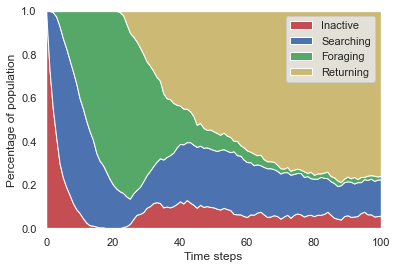

In [52]:
#%%bgc #fbd6d7

results = model47.run() 
fig, ax = plt.subplots()
foraging_stackplot(results.variables.ForagingModel, ax)

██████████████████████████████████████████

## Old animation code (slower, all green)

In [62]:
#%%bgc #fbd6d7
def animation_plot(model, ax):
    ax.set_title(f"Foraging model \n Time-step: {model.t}")
    print("t = ", model.t)
    pos = model.space.positions.values()
    pos = np.array(list(pos)).T  # Transform
    ax.scatter(*pos, s=2, c='green')# all green
    #ax.scatter(*pos, s=2, color=plt.scatter.cmap(0.7)) #didn't work
    #colorlist = ['green', 'red', 'pink', 'cyan']
    #for group in [model47.bees, model47.resources, model47.hive]:
         #ax.scatter(*pos, s=2, c = colorlist[0])
         #plt.scatter(*pos, size =2, c = colorlist[0])
         #colorlist = colorlist[1:]
    ax.set_xlim(0, model.p.land_size)
    ax.set_ylim(0, model.p.land_size)
    
fig, ax = plt.subplots()
model47 = ForagingModel(parameters)
animation = ap.animate(model47, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml())